# Setup Notebook and GPU

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-1edc38dc-dd8b-ccf7-480b-94d2a92771b4)


In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz


# Sequence Tagging Pipeline

## Import Libraries

In [ ]:
! pip install flair # https://github.com/flairNLP/flair

     |████████████████████████████████| 284 kB 15.6 MB/s 
     |████████████████████████████████| 788 kB 31.5 MB/s 
     |████████████████████████████████| 1.2 MB 67.5 MB/s 
     |████████████████████████████████| 981 kB 70.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.6 MB 58.1 MB/s 
     |████████████████████████████████| 64 kB 3.5 MB/s 
     |████████████████████████████████| 776.8 MB 13 kB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 19.7 MB 75 kB/s 
     |████████████████████████████████| 62 kB 947 kB/s 
     |████████████████████████████████| 3.3 MB 66.2 MB/s 
     |████████████████████████████████| 895 kB 55.0 MB/s 
     |████████████████████████████████| 636 kB 72.2 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9705 sha256=5d09649d6600f1760b05e680feec45599793b849d214

Our aim to successfully train a custom NER/Sequence Tagging model. We are going to use Flair library (Link: https://github.com/flairNLP/flair), which is a powerful framework for Natural language processing build using PyTorch and even provides its own flair embeddings, assistance in number of NLP tasks like POS tagging, Named entity recognization, text classification. It even includes embeddings trained using powerful models like BERT and ELMO.

## Simple NER task performed using Flair

In [ ]:
from flair.data import Sentence                               # The sentence objects holds a sentence that we may want to embed or tag
from flair.models import SequenceTagger

tagger = SequenceTagger.load('ner')                           # Pre-trained Sequence tagger of Flair
sentence = Sentence('George Washington went to Washington .') # Sentence holds a textual sentence and is essentially a list of Token
tagger.predict(sentence)
print(sentence.to_tagged_string())

for entity in sentence.get_spans('ner'):
  print(entity)

2021-08-10 22:52:02,984 --------------------------------------------------------------------------------
2021-08-10 22:52:02,985 The model key 'ner' now maps to 'https://huggingface.co/flair/ner-english' on the HuggingFace ModelHub
2021-08-10 22:52:02,986  - The most current version of the model is automatically downloaded from there.
2021-08-10 22:52:02,988  - (you can alternatively manually download the original model at https://nlp.informatik.hu-berlin.de/resources/models/ner/en-ner-conll03-v0.4.pt)
2021-08-10 22:52:02,989 --------------------------------------------------------------------------------



2021-08-10 22:52:11,577 loading file /root/.flair/models/ner-english/4f4cdab26f24cb98b732b389e6cebc646c36f54cfd6e0b7d3b90b25656e4262f.8baa8ae8795f4df80b28e7f7b61d788ecbb057d1dc85aacb316f1bd02837a4a4
George <B-PER> Washington <E-PER> went to Washington <S-LOC> .
Span [1,2]: "George Washington"   [− Labels: PER (0.9989)]
Span [5]: "Washington"   [− Labels: LOC (0.9942)]


In [ ]:
print(sentence.to_dict(tag_type='ner')) # confidence score of each predicted state

{'text': 'George Washington went to Washington .', 'labels': [], 'entities': [{'text': 'George Washington', 'start_pos': 0, 'end_pos': 17, 'labels': [PER (0.9989)]}, {'text': 'Washington', 'start_pos': 26, 'end_pos': 36, 'labels': [LOC (0.9942)]}]}


## Learning on custom entities/ Sequence Tagging
The task described in the given problem is generally defined as sequence tagging or sequence labelling in the literature. 

According to Wikipedia: In machine learning, sequence labeling is a type of pattern recognition task that involves the algorithmic assignment of a categorical label to each member of a sequence of observed values. A common example of a sequence labeling task is part of speech tagging, which seeks to assign a part of speech to each word in an input sentence or document. (Reference : https://en.wikipedia.org/wiki/Sequence_labeling)

Chapter 9 of Book by Dan Jurafsky and James H. Martin, Speech and Language Processing goes in great depth by presenting deep learning models for sequence processing. (Reference: https://web.stanford.edu/~jurafsky/slp3/)

#### Importing data

In [ ]:
from flair.data import Corpus # Corpus represents a dataset that you use to train a model. It consists of a list of train sentences, a list of dev sentences, and a list of test sentences, which correspond to the training, validation and testing split during model training
from flair.datasets import ColumnCorpus # To read a dataset, column structure as a dictionary and instantiate a ColumnCorpus

# define columns, our data is in a format where first column is tag and second is word
columns = {0:'ner',1:'text'}
data_folder = './'
# init a corpus using column format, data folder and the names of the train and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='engtrain.txt',
                              test_file='engtest.txt')

2021-08-10 22:52:41,245 Reading data from .
2021-08-10 22:52:41,247 Train: engtrain.txt
2021-08-10 22:52:41,249 Dev: None
2021-08-10 22:52:41,250 Test: engtest.txt


Note : the Column Corpus reads the data, in following format
* Sentences in the corpus are separated by an empty line
* Each row have two columns, the word and the tag that needs to be learned.

Our input data was in desired format so no data preprocessing was required in this case. Otherwise an additional step of preprocessing for converting data in format that ColumnCorpus accepts would be necessary.

#### Train/Test set size

In [ ]:
print("Length of Training set: ",len(corpus.train)) # Number of example in training set
print("Length of Test set: ",len(corpus.test))      # Number of example in test set

Length of Training set:  8797
Length of Test set:  2443


#### Displaying an example from train set

In [ ]:
print(corpus.train[0].to_tagged_string('ner')) # Displaying first example from train set
"""
O	show
O	me
O	films
O	with
B-ACTOR	drew
I-ACTOR	barrymore
O	from
O	the
B-YEAR	1980s
"""

show me films with drew <B-ACTOR> barrymore <I-ACTOR> from the 1980s <B-YEAR>


## Model training

In [ ]:
tag_type = 'ner' # tag to predict, column (we are predicting column 'ner')

In [ ]:
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type) # create a tag dictionary from the corpus
print(tag_dictionary) # classes of tags from which predictions will belong

Dictionary with 28 tags: <unk>, O, B-ACTOR, I-ACTOR, B-YEAR, B-TITLE, B-GENRE, I-GENRE, B-DIRECTOR, I-DIRECTOR, B-SONG, I-SONG, B-PLOT, I-PLOT, B-REVIEW, B-CHARACTER, I-CHARACTER, B-RATING, B-RATINGS_AVERAGE, I-RATINGS_AVERAGE, I-TITLE, I-RATING, B-TRAILER, I-REVIEW, I-YEAR, I-TRAILER, <START>, <STOP>


#### Word Embeddings
Flair provides a number of pre-trained model for embedding creation such as BERT, ELMO. (Reference : https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md). We will be using glove embeddings.

In [ ]:
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings 
# StackedEmbeddings : combine different embeddings together, for instance if you want to use both traditional embeddings together with contextual string embeddings.
from typing import List
embedding_types : List[TokenEmbeddings] = [
        WordEmbeddings('glove'), # GloVe embeddings are PyTorch vectors of dimensionality 100.
        ## other embeddings
        ]
embeddings : StackedEmbeddings = StackedEmbeddings(
                                 embeddings=embedding_types)

2021-08-10 22:56:08,207 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpkvkg3904


100%|██████████| 160000128/160000128 [00:04<00:00, 38409676.22B/s]

2021-08-10 22:56:12,443 copying /tmp/tmpkvkg3904 to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2021-08-10 22:56:12,591 removing temp file /tmp/tmpkvkg3904
2021-08-10 22:56:14,729 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmpt5j6b11u


100%|██████████| 21494764/21494764 [00:00<00:00, 34372858.83B/s]

2021-08-10 22:56:15,430 copying /tmp/tmpt5j6b11u to cache at /root/.flair/embeddings/glove.gensim
2021-08-10 22:56:15,453 removing temp file /tmp/tmpt5j6b11u


#### Training a Sequence Tagger
Sequence Tagger used here is a bi-directional LSTM (Reference : https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) for better generalization and capturing of relationship and sequencing among different tags.

In [ ]:
from flair.models import SequenceTagger # initialize sequence tagger

# Sequence tagger model source code : https://github.com/flairNLP/flair/blob/master/flair/models/sequence_tagger_model.py
tagger: SequenceTagger = SequenceTagger(hidden_size=256,                # number of hidden states in RNN
                                        embeddings=embeddings,          # word embeddings used in tagger
                                        tag_dictionary=tag_dictionary,  # dictionary of tags you want to predict
                                        tag_type=tag_type,              # string identifier for tag type
                                        use_crf=True)                   # if True use CRF decoder, else project directly to tag space
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=28, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)


In [ ]:
from flair.trainers import ModelTrainer # Initialize trainer

# ModelTrainer source code : https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
trainer: ModelTrainer = ModelTrainer(tagger, corpus) # corpus : The dataset used to train the model, should be of type Corpus and tagger : Sequence Tagger model
# training process
trainer.train('resources/taggers/example-pos',
              learning_rate=0.1,                     # Initial learning rate
              mini_batch_size=32,                    # Size of mini-batches during training
              max_epochs=150)                        # Maximum number of epochs to train. Terminates training if this number is surpassed.

2021-08-10 22:56:51,355 ----------------------------------------------------------------------------------------------------
2021-08-10 22:56:51,357 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=28, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2021-08-10 22:56:51,359 ----------------------------------------------------------------------------------------------------
2021-08-10 22:56:51,360 Corpus: "Corpus: 8797 train + 978 dev + 2443 test sentences"
2021-08-10 22:56:51,361 ----------------------------------------------------------------------------------------------------
2021-08-10 22:56:51,362 Parameters:
2021-08-10 22:56:51,364  - learning

{'dev_loss_history': [8.350046157836914,
  3.6717288494110107,
  3.112675189971924,
  2.752936601638794,
  2.6070942878723145,
  2.447624683380127,
  2.2388458251953125,
  2.2438907623291016,
  2.0877411365509033,
  2.0780882835388184,
  2.027496814727783,
  1.8975800275802612,
  1.8896929025650024,
  1.883002758026123,
  1.8897616863250732,
  1.8667683601379395,
  1.7645069360733032,
  1.8393474817276,
  1.7648714780807495,
  1.78157377243042,
  1.7588436603546143,
  1.7639039754867554,
  1.7452330589294434,
  1.778531551361084,
  1.763561725616455,
  1.6823792457580566,
  1.6573522090911865,
  1.6564821004867554,
  1.6109166145324707,
  1.6081266403198242,
  1.626693606376648,
  1.5893868207931519,
  1.6187775135040283,
  1.6264700889587402,
  1.6179977655410767,
  1.6392091512680054,
  1.6004177331924438,
  1.5906106233596802,
  1.5771229267120361,
  1.5926176309585571,
  1.5777183771133423,
  1.5826704502105713,
  1.5750762224197388,
  1.5686516761779785,
  1.574697494506836,
  1.5

#### Results

In [ ]:
# Individual class scores and overall scores, generated in the training.log file (at the very end).
# https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
"""
Results:
- F1-score (micro) 0.8695
- F1-score (macro) 0.7603

By class:
ACTOR      tp: 761 - fp: 92 - fn: 51 - precision: 0.8921 - recall: 0.9372 - f1-score: 0.9141
CHARACTER  tp: 55 - fp: 21 - fn: 35 - precision: 0.7237 - recall: 0.6111 - f1-score: 0.6627
DIRECTOR   tp: 392 - fp: 25 - fn: 64 - precision: 0.9400 - recall: 0.8596 - f1-score: 0.8981
GENRE      tp: 1046 - fp: 152 - fn: 71 - precision: 0.8731 - recall: 0.9364 - f1-score: 0.9037
PLOT       tp: 329 - fp: 115 - fn: 162 - precision: 0.7410 - recall: 0.6701 - f1-score: 0.7037
RATING     tp: 460 - fp: 41 - fn: 40 - precision: 0.9182 - recall: 0.9200 - f1-score: 0.9191
RATINGS_AVERAGE tp: 387 - fp: 57 - fn: 64 - precision: 0.8716 - recall: 0.8581 - f1-score: 0.8648
REVIEW     tp: 3 - fp: 2 - fn: 53 - precision: 0.6000 - recall: 0.0536 - f1-score: 0.0984
SONG       tp: 27 - fp: 15 - fn: 27 - precision: 0.6429 - recall: 0.5000 - f1-score: 0.5625
TITLE      tp: 457 - fp: 99 - fn: 105 - precision: 0.8219 - recall: 0.8132 - f1-score: 0.8175
TRAILER    tp: 26 - fp: 6 - fn: 4 - precision: 0.8125 - recall: 0.8667 - f1-score: 0.8387
YEAR       tp: 678 - fp: 44 - fn: 42 - precision: 0.9391 - recall: 0.9417 - f1-score: 0.9404
"""

In [ ]:
# Read the loss.tsv
import pandas as pd
df = pd.read_csv('resources/taggers/example-pos/loss.tsv', sep='\t', header=0)
df

,EPOCH,TIMESTAMP,BAD_EPOCHS,LEARNING_RATE,TRAIN_LOSS,DEV_LOSS,DEV_PRECISION,DEV_RECALL,DEV_F1
0,1,22:57:15,0,0.1000,11.353004,8.350046,0.5305,0.5318,0.5312
1,2,22:57:40,0,0.1000,5.606176,3.671729,0.7462,0.6973,0.7209
2,3,22:58:05,0,0.1000,4.395019,3.112675,0.7898,0.7279,0.7576
3,4,22:58:31,0,0.1000,3.850331,2.752937,0.8031,0.7547,0.7781
4,5,22:58:55,0,0.1000,3.466244,2.607094,0.8351,0.7724,0.8025
...,...,...,...,...,...,...,...,...,...
63,64,23:21:36,4,0.0004,1.650943,1.565202,0.8780,0.8670,0.8725
64,65,23:21:59,1,0.0002,1.675382,1.565174,0.8780,0.8670,0.8725
65,66,23:22:22,2,0.0002,1.656760,1.565436,0.8780,0.8670,0.8725
66,67,23:22:46,3,0.0002,1.666056,1.565295,0.8780,0.8670,0.8725


* Final training loss : 1.645139
* Final dev loss : 1.564637
* Final dev precision : 0.8780	
* Final dev recall : 0.8670
* Final dev F1 score : 0.8725

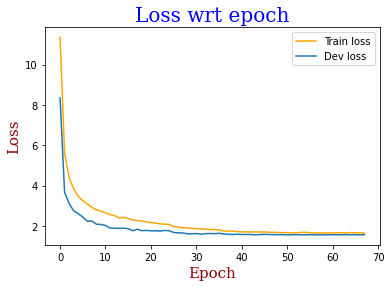

In [ ]:
import matplotlib.pyplot as plt
font = {'family':'serif','color':'darkred','size':15}
fontHead = {'family':'serif','color':'blue','size':20}

plt.plot(df["TRAIN_LOSS"],color="orange",label='Train loss')
plt.plot(df["DEV_LOSS"],label='Dev loss')
plt.xlabel("Epoch",fontdict = font)
plt.ylabel("Loss",fontdict = font)
plt.title("Loss wrt epoch",fontdict=fontHead)
plt.legend(loc='best')
plt.show()

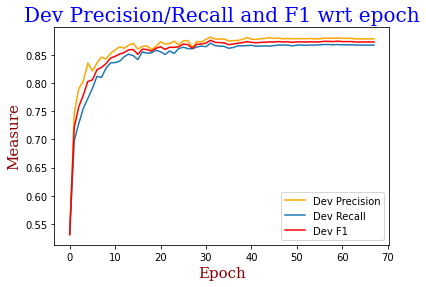

In [ ]:
import matplotlib.pyplot as plt
font = {'family':'serif','color':'darkred','size':15}
fontHead = {'family':'serif','color':'blue','size':20}

plt.plot(df["DEV_PRECISION"],color="orange",label='Dev Precision')
plt.plot(df["DEV_RECALL"],label='Dev Recall')
plt.plot(df["DEV_F1"],color="red",label='Dev F1')
plt.xlabel("Epoch",fontdict = font)
plt.ylabel("Measure",fontdict = font)
plt.title("Dev Precision/Recall and F1 wrt epoch",fontdict=fontHead)
plt.legend(loc='best')
plt.show()

#### Few Prediction made by trained model on test set
The predcitions can be viewed in the file generated test.tsv.
It contains predictions as follows, wher first column is the word, second is the actual tag and third is the predicted tag:

In [ ]:
# First example of test file. all tags are correctly predicted except the year ones (Format: Word, Actual Tag, Predicted Tag)
"""
are O O
there O O
any O O
good O O
romantic B-GENRE B-GENRE
comedies I-GENRE I-GENRE
out O O
right B-YEAR O
now I-YEAR O
"""

In [ ]:
# Second example of test file, all tags correctly predicted
"""
show O O
me O O
a O O
movie O O
about O O
cars B-PLOT B-PLOT
that I-PLOT I-PLOT
talk I-PLOT I-PLOT
"""

#### Some prediction made by self made example

In [ ]:
model = SequenceTagger.load('resources/taggers/example-pos/final-model.pt') # load the trained model

2021-08-10 23:29:24,283 loading file resources/taggers/example-pos/final-model.pt


In [ ]:
sentence = Sentence('list the five star rated movies starring mel gibson')
model.predict(sentence) # predict the tags
print(sentence.to_tagged_string())

list the five <B-RATINGS_AVERAGE> star <I-RATINGS_AVERAGE> rated movies starring mel <B-ACTOR> gibson <I-ACTOR>


In [ ]:
sentence = Sentence('want to see an indian movie')
model.predict(sentence) # predict the tags
print(sentence.to_tagged_string())

want to see an indian <B-GENRE> movie


In [ ]:
sentence = Sentence('which is the latest movie directed by Martin Scorsese')
model.predict(sentence) # predict the tags
print(sentence.to_tagged_string())

which is the latest movie directed by Martin <B-DIRECTOR> Scorsese <I-DIRECTOR>


It works good!!